# Analiza: Wykrywanie języka na podstawie częstotliwości słów w tekscie

Celem tej pracy jest ocena, czy na podstawie danych dotyczących częstotliwości występowania słów w arytkule na wybranym wiki (u nas bulbapedia) da się rozpoznać język tekstu. Eksperyment polega na porównaniu listy najczęsciej występujących słów na wiki z listą najczęściej występujących słów w jednym z trzech języków. Sprawdzimy dodatkowo jak na poprawność metody wpływa długość arytkułu.

In [62]:
# Początkowe importy najważniejszych modułów i bibliotek
import re
import matplotlib.pyplot as plt
from wordfreq import top_n_list, word_frequency
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd

Wykorzystamy listy najczęsciej występujących słów z trzech języków: polskiego, angielskiego (język naszej wiki), oraz niemieckiego. Użyjemy do tego biblioteki wordfreq.

In [63]:
# Zwraca liniową ilość wystąpień słowa 'na jedno słowo' w języku
def get_language_words(lang: str, n: int = 1000) -> dict[str, float]:
    words = top_n_list(lang, n)
    return {w: word_frequency(w, lang) for w in words}

langs = ["en", "pl", "de"]

lang_freq = {lang: get_language_words(lang) for lang in langs}

Na potrzeby analizy stworzymy nowy uniwersalny scraper, który zadziała dla każdej strony, nie tylko bulbapedii.

In [64]:
# Nasza funkcja scrapująca zwraca obiekt bs, który potem będziemy edytować zależnie od struktury html
def get_article(url):
    # Tworzymy header, który pozwoli nam się dostać do stron używając headera z httpbin.org/cache
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:147.0) Gecko/20100101 Firefox/147.0"
    }

    try:
        source = requests.get(url, headers=headers)
    except requests.RequestException:
        return None

    if source.status_code != 200:
        print(f"Błąd: status_code={source.status_code} dla {url}")
        return None

    return BeautifulSoup(source.text, "html.parser")


Jako dłuższy artykuł z wybranej wiki (bulbapedii) posłuży strona z opisami umiejętności pokemonów: [https://bulbapedia.bulbagarden.net/wiki/Ability]. Pobierzmy html tej strony używając naszej nowej funkcji.

In [65]:
lo_soup = get_article("https://bulbapedia.bulbagarden.net/wiki/Ability")

Zrobimy to samo dla krótkiego arytkuły ze strony [https://bulbapedia.bulbagarden.net/wiki/Bulbakaki], który pełen jest nazw własnych.

In [66]:
sh_soup = get_article("https://bulbapedia.bulbagarden.net/wiki/Bulbakaki")

Robimy to również dla artykułów w każdym z wybranych języków:

In [67]:
pl_soup = get_article("https://wolnelektury.pl/katalog/lektura/witkacy-o-czystej-formie.html")
en_soup = get_article("https://en.wikipedia.org/wiki/Beer")
de_soup = get_article("https://wolnelektury.pl/katalog/lektura/heyse-die-schwarze-jakobe.html")

# Usuwamy polskie słowa z niemieckiego tekstu (bo pobieramy z polskiej strony)
for h2 in de_soup.find_all("h2"):
    h2.decompose()

Zdefiniujmy funkcję do liczenia słów zwracającą słownik:

In [68]:
def count_words(text) -> dict:
    word_dict = {}

    for word in text:
        word_dict[word] = word_dict.get(word, 0) + 1

    return word_dict


Teraz musimy w każdej z tych struktur znaleźć właściwą zawartość z artykułem, zamienić ją na tekst i policzyć słowa:

In [75]:
# Wycinanie właściwej zawartości (find zwraca typ tag)
sh_content = sh_soup.find("p")
lo_content = lo_soup.find("div", class_="mw-body-content")
pl_content = pl_soup.find("div", class_="main-text-body")
en_content = en_soup.find("div", id="mw-content-text")
de_content = de_soup.find("div", class_="main-text-body")

contents = {
    "short_en": sh_content,
    "long_en": lo_content,
    "pl_article": pl_content,
    "en_article": en_content,
    "de_article": de_content,
}

dicts = {}

for name, c in contents.items():
    # Zmieniamy typ na string
    text = c.get_text(" ", strip=True)

    # Tokenizacja
    tokens = re.findall(r"[^\W\d_]+", text.lower())
    # Tworzymy słowniki z licznikiem wystąptień
    res: dict[str, int] = count_words(tokens)
    # Sortujemy
    sorted_dict = dict(sorted(res.items(), key=lambda x: x[1], reverse=True))
    # Wstawiamy do dicts
    dicts[name] = sorted_dict


Upewnijmy się, że wszystko działa wypisując pare pierwszych słów:

In [76]:
for name, d in dicts.items():
    print(name)
    print(list(d.items())[:100])

short_en
[('the', 3), ('to', 3), ('bulbagarden', 2), ('oekaki', 2), ('users', 2), ('bulbakaki', 2), ('was', 2), ('known', 1), ('its', 1), ('as', 1), ('an', 1), ('run', 1), ('by', 1), ('which', 1), ('used', 1), ('wacintaki', 1), ('poteto', 1), ('there', 1), ('is', 1), ('a', 1), ('deviantart', 1), ('group', 1), ('for', 1), ('of', 1), ('upload', 1), ('their', 1), ('completed', 1), ('artworks', 1), ('it', 1), ('closed', 1), ('down', 1), ('in', 1)]
long_en
[('the', 847), ('s', 540), ('pokémon', 500), ('in', 428), ('a', 286), ('ability', 285), ('to', 280), ('its', 247), ('and', 241), ('of', 237), ('it', 168), ('moves', 139), ('abilities', 132), ('from', 121), ('battle', 118), ('when', 114), ('activated', 113), ('used', 110), ('with', 110), ('is', 108), ('by', 93), ('iii', 91), ('that', 87), ('type', 80), ('stat', 70), ('was', 68), ('damage', 63), ('as', 62), ('have', 61), ('hidden', 58), ('or', 56), ('iv', 55), ('attack', 54), ('vii', 53), ('an', 52), ('v', 52), ('ix', 50), ('power', 49), ('

Pora zdefiniować funckje szacującą język tekstu. Pomysł: liczymy współczynnik **COVERAGE** czyli jaka część wszystkich słów w tekście należy do top-N słów danego języka oraz **COSINE SIMILARITY** czyli porównujemy proporcje tych top-słów w tekście do proporcji w profilu języka (wpisujemy słowa w wektory i patrzymy na kąt pomiędzy nimi mówiący czy idą w tą samą stronę). Wynikiem końcowym będzie coverage * cosine. Zacznijmy od funkcji porównującej proporcje, wzór to:
$$
\cos(\theta)=\frac{x\cdot y}{\|x\|\|y\|}
$$
Gdzie $0^\circ$ oznacza całkowite podobieństwo, a $90^\circ$ jego brak. nie otrzymamy ujemych wartości bo wszystkie el. w wektorach są dodatnie.

Nasza norma wektora to:
$$
\|x\| = \sqrt{\sum_{i=1}^{n} x_i^2}
$$


In [77]:
def cosine_similarity(vec_a: dict[str, float], vec_b: dict[str, float]) -> float:
    # Ustalamy wspólną liste słów dla obu wektorów
    keys = set(vec_a.keys()) | set(vec_b.keys())

    # Iloczyn skalarny wektorów i ich normy
    dot = 0.0 
    norm_a = 0.0
    norm_b = 0.0

    # Iterujemy po każdym słowie i uzupełniamy dane
    for k in keys:
        a = vec_a.get(k, 0.0)
        b = vec_b.get(k, 0.0)

        dot += a * b
        norm_a += a * a
        norm_b += b * b

    # Obliczamy normy
    norm_a = math.sqrt(norm_a)
    norm_b = math.sqrt(norm_b)

    # Dla wektorów pustych zwróć 0 dopasowania
    if norm_a == 0.0 or norm_b == 0.0:
        return 0.0
    
    # Zwróc współczynnik cos pomiędzy 0 a 90 stopni
    return dot / (norm_a * norm_b)


Zdefiniujmy funkcję, która na bazie coverage i cosine similarity obliczy współczynnik dopasowania języka, zwracającą wynik 0..1 gdzie 0 to brak dopasowania a 1 to pewne dopasowanie.

In [ ]:
def lang_confidence_score(word_counts: dict[str, int],
                          language_words_with_frequency: dict[str, float],
                          k=1000) -> float:
    # Wybierzmy top k słów aby dostać k par (słowo : częstotliwość)
    topk = sorted(language_words_with_frequency.items(), key=lambda x: x[1], reverse=True)[:k]
    # Lista samych słów
    topk_words = [w for w, _ in topk]

    # Policzymy total do normalizacji słów wiki
    total = sum(word_counts.values())
    if total <= 0:
        return 0.0
    
    # Obliczmy nasz coverage czyli procent pokrycia słów z wiki ze słowami z języka
    in_topk = sum(word_counts.get(w, 0) for w in topk_words)
    coverage = in_topk / total

    # Tworzymy wektor (słownik) słowo - częstotliwość do naszej funckji cosine
    lang_vec = {w: fr for w, fr in topk}
    sum_lang = sum(lang_vec.values())
    # Normalizujemy
    if sum_lang == 0:
        return 0.0
    lang_vec = {w: fr / sum_lang for w, fr in lang_vec.items()}
    
    # Robimy to samo dla wektora słów wiki 
    art_vec = {w: word_counts.get(w, 0) for w in topk_words}
    sum_doc = sum(art_vec.values())
    if sum_doc == 0:
        return 0.0
    doc_vec = {w: c / sum_doc for w, c in art_vec.items()}

    cos = cosine_similarity(doc_vec, lang_vec)

    return float(cos * coverage)

Trzeba policzyc i zapisać uporządkowane wyniki do jednego DataFrame.

In [73]:
ks = [3, 10, 100, 1000]

rows = []
for lang_name, lang_dict in lang_freq.items():
    for name, count in dicts.items():
        for k in ks:
            score = lang_confidence_score(count, lang_dict, k=k)
            rows.append({
                "language": lang_name,
                "doc": name,
                "k": k,
                "score": score,
            })

df = pd.DataFrame(rows)
print(df)

   language         doc     k     score
0        en    short_en     3  0.127669
1        en    short_en    10  0.233460
2        en    short_en   100  0.380766
3        en    short_en  1000  0.441015
4        en     long_en     3  0.091845
5        en     long_en    10  0.167760
6        en     long_en   100  0.297758
7        en     long_en  1000  0.421172
8        en  pl_article     3  0.003838
9        en  pl_article    10  0.015364
10       en  pl_article   100  0.018181
11       en  pl_article  1000  0.023747
12       en  en_article     3  0.086672
13       en  en_article    10  0.173822
14       en  en_article   100  0.264871
15       en  en_article  1000  0.437372
16       en  de_article     3  0.000000
17       en  de_article    10  0.002866
18       en  de_article   100  0.007095
19       en  de_article  1000  0.009910
20       pl    short_en     3  0.000000
21       pl    short_en    10  0.021121
22       pl    short_en   100  0.034732
23       pl    short_en  1000  0.059526


Z gotowych danych pozostaje zrobić nam wykresy:

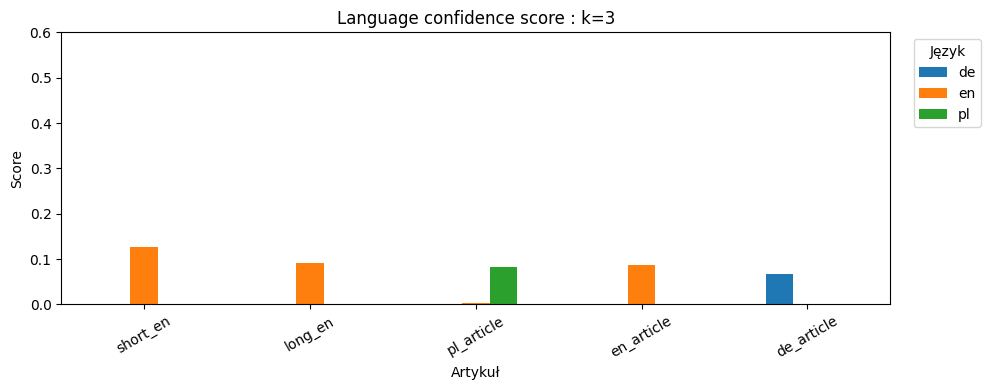

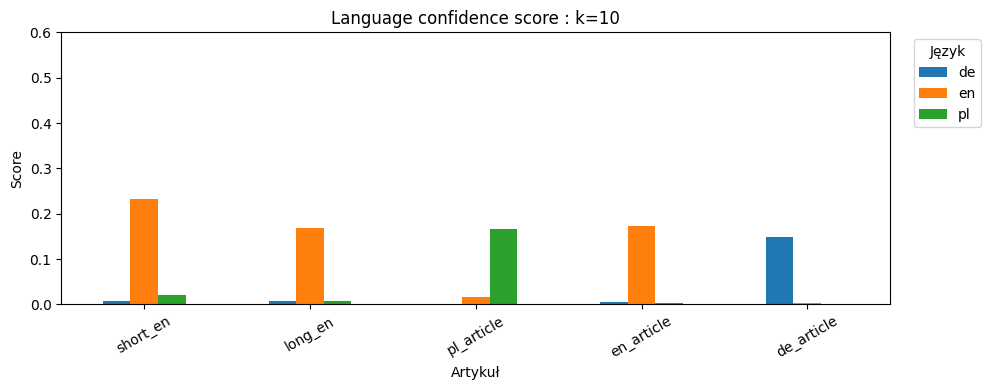

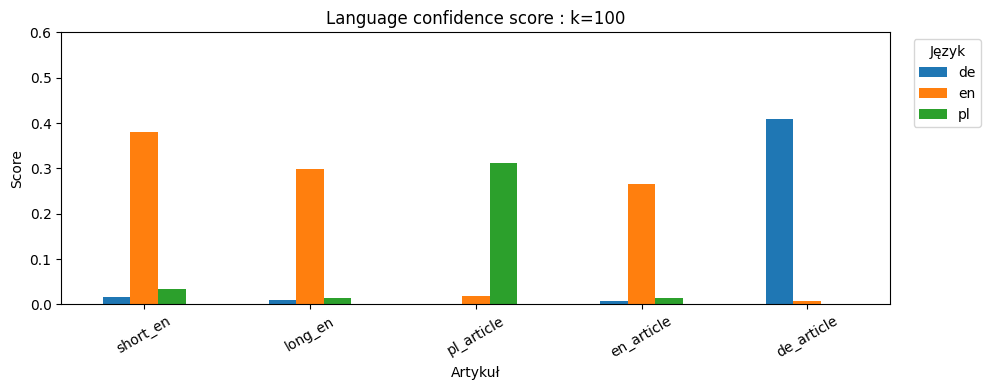

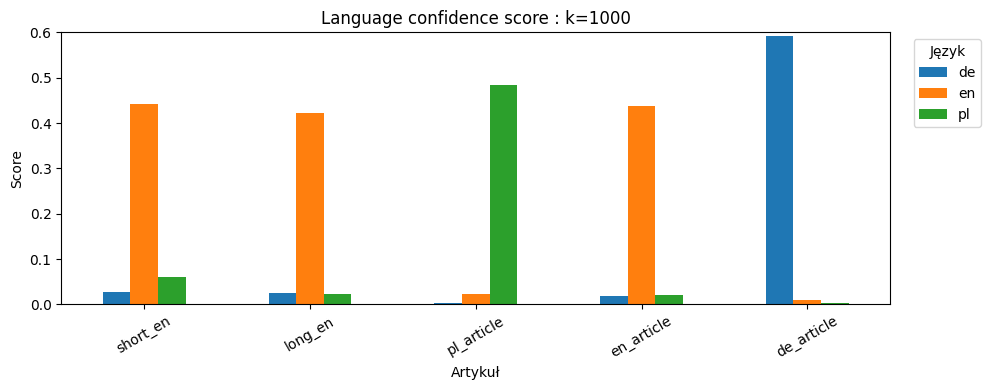

In [74]:
# doc to nazwy naszych artykułów wybrane z df
doc = df['doc'].unique()

# Każde K to oddzielny wykres
for k in ks:
    # Bierzemy z naszego df wiersze dla aktualnego k
    sub = df[df["k"] == k]

    # Robimy tabelę: wiersze = dokumenty, kolumny = języki, wartości = score
    pivot = sub.pivot(index="doc", columns="language", values="score")

    # Wymuszamy kolejność dokumentów jak w doc_order
    pivot = pivot.loc[doc]

    # Rysujemy wykres słupkowy z danych pivot..
    ax = pivot.plot(kind="bar", figsize=(10, 4))

    # Tytuł wykresu
    ax.set_title(f"Language confidence score : k={k}")

    # Opisy osi
    ax.set_xlabel("Artykuł")
    ax.set_ylabel("Score")

    # Stałe y dla normalizacji
    ax.set_ylim(0, 0.6)

    # Obrót etykiet na osi X, żeby się mieściły
    ax.tick_params(axis="x", rotation=30)

    # Legenda poza wykresem (po prawej), żeby nie zasłaniała słupków
    ax.legend(title="Język", bbox_to_anchor=(1.02, 1), loc="upper left")

    # Dopasowanie marginesów, żeby wszystko (np. legenda) się zmieściło
    plt.tight_layout()

    # Wyświetlenie wykresu
    plt.show()


## PODSUMOWANIE ##
1. Analizując wykresy funkcji zauważamy, że współczynnik dopasowania języka do tego, w którym strona została faktycznie napisana rośnie proporcjonalnie do współczynnika k. Jest to naturalne, im większa próbka słów, tym dopasowanie pewniejsze.
2. Proporcjonalnie wyniki dla różnych k nie różnią się, tzn. np dla pełnego nazw własnych short_en już od k = 10 pojawiają się sugestie wystąpienia języka polskiego lub niemieckiego lecz ich proporcja do faktycznego języka jest zachowana.
3. Najmniej różnorodne pod względem ilości języków na artykuł jest oczywiści k = 3 gdzie występuje tak naprawdę tylko faktyczny język.
4. Już od k = 3 nasza funkcja dobrze rozpoznaje język (nawet za dobrze bo nie udało mi się znaleźć artukułu dającego gorszy wynik niż short_en a i tak nie jest zły).
5. Widzimy, że skuteczność dopasowania będziemy tak naprawdę oceniać po różnicy wysokości najbardziej prawdopodobnego języka, a dwóch pozostałych. Dla niemieckiego artykułu np. język jest pewny a dla short_en występuje rozproszenie na dwa pozostałe języki.
6. Dobór języków miał znaczenie, polski i niemiecki, które mają znaki charakterystyczne łatwiej jest wykryć niż angielski, szczególnie niemiecki.
7. W samych wartościach score widać pośrednio wpływ odmiany: dla języków fleksyjnych (PL i DE) wynik rośnie znacznie mocniej po zwiększeniu k, co sugeruje, że dopasowanie wymaga uwzględnienia większej liczby form wyrazów. To jest spójne z tym, że częste słowa w tych językach występują w wielu odmienionych wariantach, więc przy małym k miara “łapie” ich mniej, a dopiero większe k obejmuje więcej odmian.
8. Znalezienie słabego artykułu było bardzo ciężkie, nasza funkcja jest na tyle dobra, że i tak daje miarodajne efekty. Jedyne po czym widać to, że artykuł jest słaby to fakt, że pomimo wzrostu k wysokość słupka nie rośnie (ok. 0.4) kiedy innych artykułów gwałtownie rosną kiedy zwiększa się liczba słów. Jest to spowodowane tym, że short_en jest krótki i po prostu ma ograniczoną liczbę słów. Oprócz tego, słaby artykuł daje też większą szansę na inne języki niż faktyczny, czyli funkja dla niego jest mniej miarodajna.